In [1]:
import audacity as au
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import FluteTransients as ftr

%matplotlib notebook

In [2]:
# Listing relevant datafiles
acquisitions = [0, 1, 2]
channel_config = (1, 2)
calib = (4.88e-04,-5.06e-04,1.14e-01) # IR sensor calibration constants

dfiles = []
for acq in acquisitions:
    acqfile = "DATA/MAIN_4500rpm/characteristic/cross/rec{}.aup".format(acq)
    dfiles.append(acqfile)

In [3]:
# Organising channels
ch_INT = []
ch_IR = []

for f in dfiles:
    auf = au.Aup(str(f))
    sr = auf.rate
    ch_INT.append(auf.get_channel_data(channel_config[0]))
    ch_IR.append(auf.get_channel_data(channel_config[1]))

In [4]:
# Obtaining key displacement and speed
keyx = []
keyv = []
keyt = []

for chdata in ch_IR:
    b, a = sig.butter(4, 1000/sr, 'high')
    IR_filt = sig.filtfilt(b, a, chdata, padtype='constant')
    IR_rms, IR_t = ftr.RMSWind(IR_filt, sr=sr, nwind=16, nhop=20)
    IR_ampl = IR_rms*np.sqrt(2)
    
    thisx, thisv = ftr.IRcalib(IR_ampl,calib)
    keyx.append(thisx)
    keyv.append(thisv)
    keyt.append(IR_t)

In [5]:
# Obtaining # Obtaining pressure-calibrated audio
intp = []

for chdata in ch_INT:
    intp.append(ftr.Pcalib(chdata, (9884.72, -19.14)))

In [6]:
# Select peak key speeds with timestamps
keyv_closing = []
keyv_opening = []

for vlist, tlist in zip(keyv,keyt):
    keyv_closing.append(ftr.get_vpeaks(vlist, tlist, max(vlist)/40, len(vlist)/65))
    keyv_opening.append(ftr.get_vpeaks(vlist, tlist, max(vlist)/50, len(vlist)/70, pk='min'))

In [7]:
# Select peak frequency change with timestamps
gradf_closing = []
gradf_opening = []

for i, chdata in enumerate(ch_INT):
    # make time axis for audio
    time = np.arange(len(chdata))/sr
    # use key speed timestamps to estimate frequency timestamps
    est_closing = keyv_closing[i][1]
    est_opening = keyv_opening[i][1]
    gradf_closing.append(ftr.get_fpeaks(chdata, time, sr, est_closing, .08))
    gradf_opening.append(ftr.get_fpeaks(chdata, time, sr, est_opening, .08))

In [8]:
# Select peak sound level change with timestamps
gradp_closing = []
gradp_opening = []

for i, chdata in enumerate(intp):
    time = np.arange(len(chdata))/sr
    est_closing = keyv_closing[i][1]
    est_opening = keyv_opening[i][1]
    gradp_closing.append(ftr.get_ppeaks(chdata, time, sr, est_closing, .08))
    gradp_opening.append(ftr.get_ppeaks(chdata, time, sr, est_opening, .08))

<IPython.core.display.Javascript object>


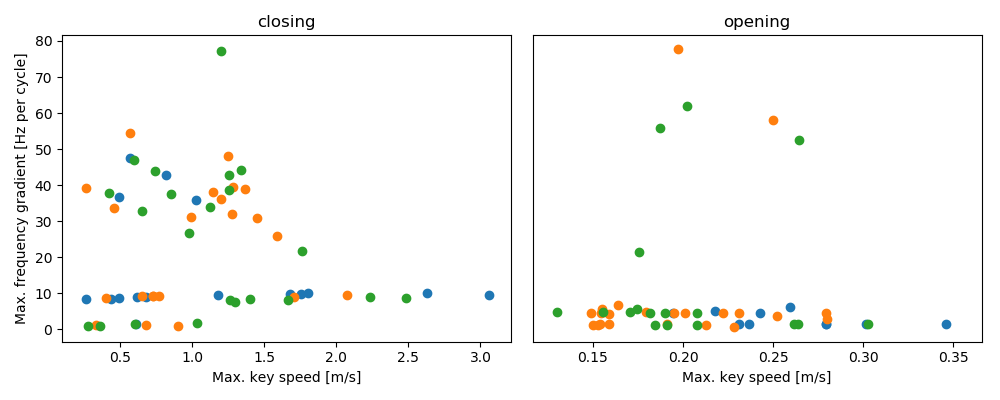

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("closing")
plt.scatter(keyv_closing[0][0], gradf_closing[0][0])
plt.scatter(keyv_closing[1][0], gradf_closing[1][0])
plt.scatter(keyv_closing[2][0], gradf_closing[2][0])
plt.xlabel("Max. key speed [m/s]")
plt.ylabel("Max. frequency gradient [Hz per cycle]")

plt.subplot(1, 2, 2)
plt.title("opening")
plt.scatter(np.abs(keyv_opening[0][0]), gradf_opening[0][0])
plt.scatter(np.abs(keyv_opening[1][0]), gradf_opening[1][0])
plt.scatter(np.abs(keyv_opening[2][0]), gradf_opening[2][0])
plt.yticks(())
plt.xlabel("Max. key speed [m/s]")
plt.tight_layout()

# plt.savefig('LT_cross_gradf.png')

<IPython.core.display.Javascript object>


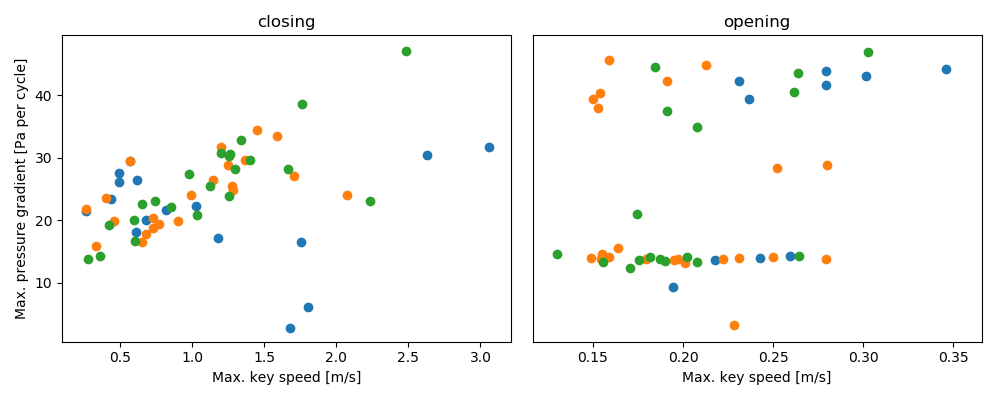

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("closing")
plt.scatter(keyv_closing[0][0], gradp_closing[0][0])
plt.scatter(keyv_closing[1][0], gradp_closing[1][0])
plt.scatter(keyv_closing[2][0], gradp_closing[2][0])
plt.xlabel("Max. key speed [m/s]")
plt.ylabel("Max. pressure gradient [Pa per cycle]")

plt.subplot(1, 2, 2)
plt.title("opening")
plt.scatter(np.abs(keyv_opening[0][0]), gradp_opening[0][0])
plt.scatter(np.abs(keyv_opening[1][0]), gradp_opening[1][0])
plt.scatter(np.abs(keyv_opening[2][0]), gradp_opening[2][0])
plt.yticks(())
plt.xlabel("Max. key speed [m/s]")
plt.tight_layout()

# plt.savefig('LT_cross_gradp')